# Customer Segementation on Data

Initially we preprocess, apply analysis. After which we use WCSS to find optimum number of clusters and call k-means clustering accordginly on the data (Which we finally visualize)

We use several methods for the k-means model

**import dependencies**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.ticker as ticker

**read the bank customer data. we use general pandas methods to get an idea of the data**

In [52]:
bank_customer_data = pd.read_csv("bank_transactions.csv")
bank_customer_data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [53]:
bank_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [54]:
bank_customer_data.shape

(1048567, 9)

**Let us also get rid of rows with na values, since we have a large enough dataset**

In [55]:
bank_customer_data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [56]:
bank_customer_data.dropna(subset=['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], inplace=True)
bank_customer_data.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [57]:
bank_customer_data.shape

(1041614, 9)

**Next, we need to ensure unique customers, hence we keep based on their mean balance and total transaction amount**

In [58]:
## OLD code: kept customer's last recorded transaction time instance
# bank_customer_data['TransactionDate'] = pd.to_datetime(bank_customer_data['TransactionDate'])
# # Sort by CustomerID, TransactionDate, and TransactionTime
# bank_customer_data = bank_customer_data.sort_values(by=['CustomerID', 'TransactionDate', 'TransactionTime'])
# # Drop duplicate CustomerIDs, keeping the last (most recent) one
# bank_customer_data = bank_customer_data.drop_duplicates(subset='CustomerID', keep='last')

We see the number of duplicate customer_ids below

In [59]:
# This gives you the count of all duplicated CustomerID entries excluding their first occurrence.
bank_customer_data['CustomerID'].duplicated().sum()

162256

In [60]:
# This gives you the count of unique CustomerIDs that have any duplicates.
# Using the previous example, both CustomerIDs would be counted once, so the result would be two.
duplicate_customer_ids = bank_customer_data['CustomerID'].value_counts()
duplicate_customer_ids = duplicate_customer_ids[duplicate_customer_ids > 1].index.tolist()
len(duplicate_customer_ids)

141961

In [61]:
# Group by CustomerID
agg_funcs = {
    'TransactionAmount (INR)': 'sum',         # Sum TransactionAmounts
    'CustAccountBalance': 'mean',             # Average Account Balance
    'CustomerDOB': 'first',                   # Keep the first DOB (assuming it's consistent across duplicate rows)
    'CustGender': 'first',                    # Keep the first Gender (assuming it's consistent across duplicate rows)
    'CustLocation': 'first'                   # Keep the first Location (assuming it's consistent across duplicate rows)
}
bank_customer_data = bank_customer_data.groupby('CustomerID').agg(agg_funcs).reset_index()
bank_customer_data

,CustomerID,TransactionAmount (INR),CustAccountBalance,CustomerDOB,CustGender,CustLocation
0,C1010011,5106.0,76340.635,19/8/92,F,NOIDA
1,C1010012,1499.0,24204.490,28/7/94,M,MUMBAI
2,C1010014,1455.0,100112.950,4/6/92,F,MUMBAI
3,C1010018,30.0,496.180,29/5/90,F,CHAMPARAN
4,C1010024,5000.0,87058.650,21/6/65,M,KOLKATA
...,...,...,...,...,...,...
879353,C9099836,691.0,133067.230,24/12/90,M,BHIWANDI
879354,C9099877,222.0,96063.460,9/6/96,M,BANGALORE
879355,C9099919,126.0,5559.750,21/10/93,M,GUNTUR
879356,C9099941,50.0,35295.920,22/4/95,M,CHENNAI


In [62]:
bank_customer_data.shape

(879358, 6)

In [63]:
bank_customer_data['CustomerID'].duplicated().sum()

0

In [64]:
duplicate_customer_ids = bank_customer_data['CustomerID'].value_counts()
duplicate_customer_ids = duplicate_customer_ids[duplicate_customer_ids > 1].index.tolist()
len(duplicate_customer_ids)

0

**We split based on CustAccountBalance and TransactionAmount (INR), since the other values don't matter (example gender, location) for our case**

In [82]:
bank_customer_financials = bank_customer_financials.rename(columns={
    bank_customer_financials.columns[0]: "TotalTransactionAmount",
    bank_customer_financials.columns[1]: "MeanCustomerBalance"
})
bank_customer_financials

,TotalTransactionAmount,MeanCustomerBalance
0,5106.0,76340.635
1,1499.0,24204.490
2,1455.0,100112.950
3,30.0,496.180
4,5000.0,87058.650
...,...,...
879353,691.0,133067.230
879354,222.0,96063.460
879355,126.0,5559.750
879356,50.0,35295.920


# Elbow Point

Let us first visualize the possible elbow points

**Choosing number of clusters WCSS -> Within Cluster Sum of Squares**

We find the centroid of different clusters, containing datapoints close to each other

This loop iterates from 1 to 12 (inclusive). I chose 12 since it was most common drop for this type of cluster data

**For each iteration**:

A KMeans clustering model is initialized with i clusters, using the 'k-means++' initialization method and a fixed random state of 42.

The KMeans model is then fit to the data (df).
The WCSS (inertia) for the clustering model is appended to the wcss list. Inertia is the sum of squared distances of samples to their closest cluster center.

In [83]:
wcss = []
for i in range (1, 13):
    kmeans = KMeans(n_clusters = i,init='k-means++', random_state=42)
    kmeans.fit(bank_customer_financials)
    wcss.append(kmeans.inertia_)

/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

**Plot elbow graph visualization**

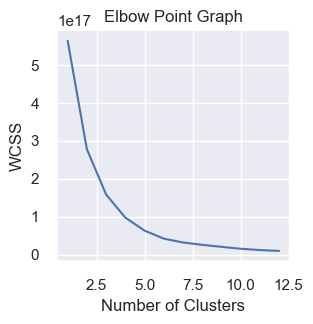

In [84]:
sns.set()
plt.figure(figsize=(3, 3))
plt.plot(range(1, 13), wcss)
plt.title("Elbow Point Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

**Finding optimal point on Elbow Graph**

We can also initalize another model to find the optimal elbow point(s) with yellowbrick clusters

**Distortion**: It is calculated as the average of the squared distances from the cluster centers of the respective clusters to each data point. Typically, the Euclidean distance metric is used.

                Distortion = 1/n * Σ(distance(point, centroid)^2)
**Inertia**: It is the sum of the squared distances of samples to their closest cluster center.

                 Inertia = Σ(distance(point, centroid)^2)
We iterate the values of k from 1 to n and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

We initialize a basic KMeans instance, create it's visualizer and finally show it fitted onto our dataframe

/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

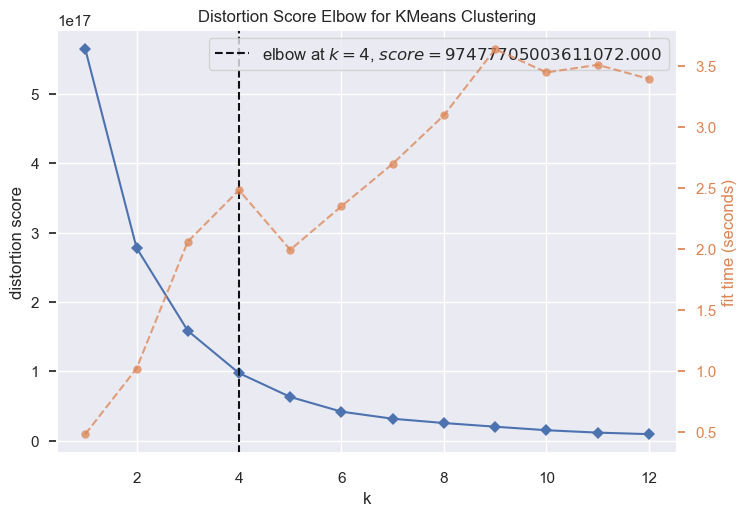

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
model = KMeans(init='k-means++', random_state=42)
visualizer = KElbowVisualizer(model, k=(1,13))
visualizer.fit(bank_customer_financials)
# labels
visualizer.ax.set_title("Customized Elbow Point Graph")
visualizer.ax.set_xlabel("Number of Clusters")
visualizer.ax.set_ylabel("WCSS Value")
visualizer.show()

**We see that the optimal number of clusters is 4 since it at this point we do not get anymore significant drop in distortion**

# KMeans Model

In [86]:
kmeans = KMeans(n_clusters = 4, init='k-means++', random_state=0)
Y = kmeans.fit_predict(bank_customer_financials)
print(Y)

/Users/amman3/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 0 0 ... 0 0 0]


In [88]:
print(len(Y))
print(np.sum(Y == 0))
print(np.sum(Y == 1))
print(np.sum(Y == 2))
print(np.sum(Y == 3))

879358
872356
378
43
6581


**Visualize clusters - We know 4 clusters are 0,1,2,3**

In [90]:
def set_lakh_formatter(ax, axis='both'):
    """
    Set the tick labels to represent values in lakhs.
    Args:
    - ax: The axis object.
    - axis: 'x', 'y', or 'both'; determines which axis will get the formatter.
    """
    def lakh_formatter(x, pos):
        return '{:.0f}L'.format(x / 1e5)
    
    if axis in ['x', 'both']:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lakh_formatter))
    
    if axis in ['y', 'both']:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lakh_formatter))

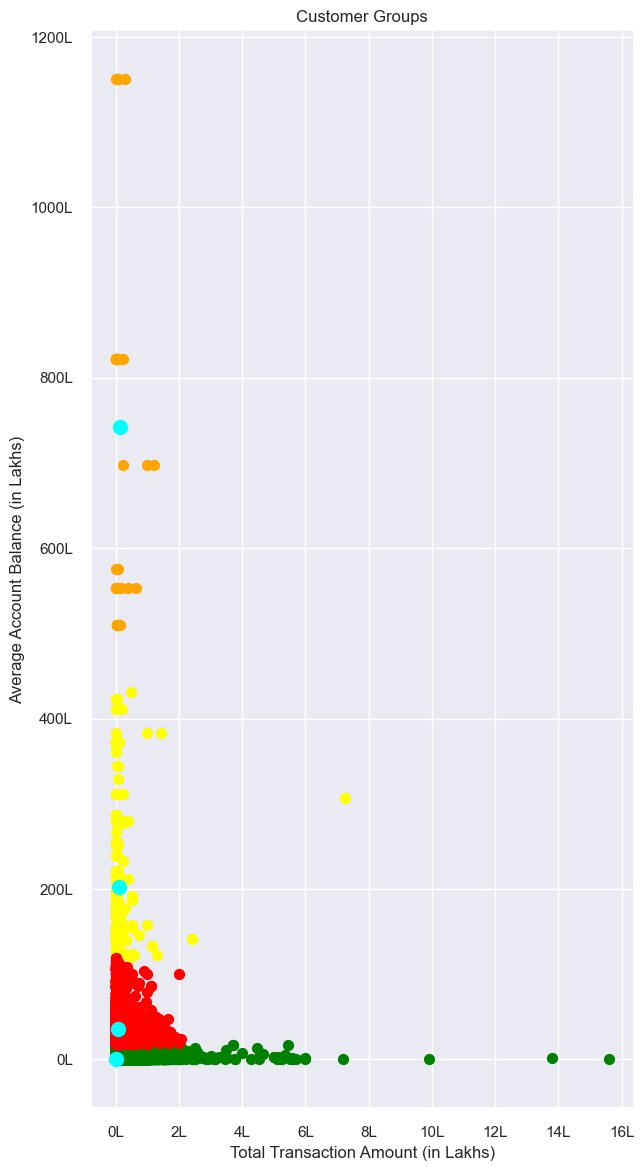

In [93]:
plt.figure(figsize=(7,14))
plt.scatter(bank_customer_financials.loc[Y==0, bank_customer_financials.columns[0]], bank_customer_financials.loc[Y==0, bank_customer_financials.columns[1]], s=50, c='green', label = 'Cluster 1')
plt.scatter(bank_customer_financials.loc[Y==1, bank_customer_financials.columns[0]], bank_customer_financials.loc[Y==1, bank_customer_financials.columns[1]], s=50, c='yellow', label = 'Cluster 2')

plt.scatter(bank_customer_financials.loc[Y==2, bank_customer_financials.columns[0]], bank_customer_financials.loc[Y==2, bank_customer_financials.columns[1]], s=50, c='orange', label = 'Cluster 3')
plt.scatter(bank_customer_financials.loc[Y==3, bank_customer_financials.columns[0]], bank_customer_financials.loc[Y==3, bank_customer_financials.columns[1]], s=50, c='red', label = 'Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='cyan', label='centroids')

# Adjust tick labels to show values in lakhs
ax = plt.gca()  # Get current axis
set_lakh_formatter(ax, 'both')  # Set both x and y axes to use lakh notation

plt.title('Customer Groups')
plt.xlabel('Total Transaction Amount (in Lakhs)')
plt.ylabel('Average Account Balance (in Lakhs)')
plt.show()